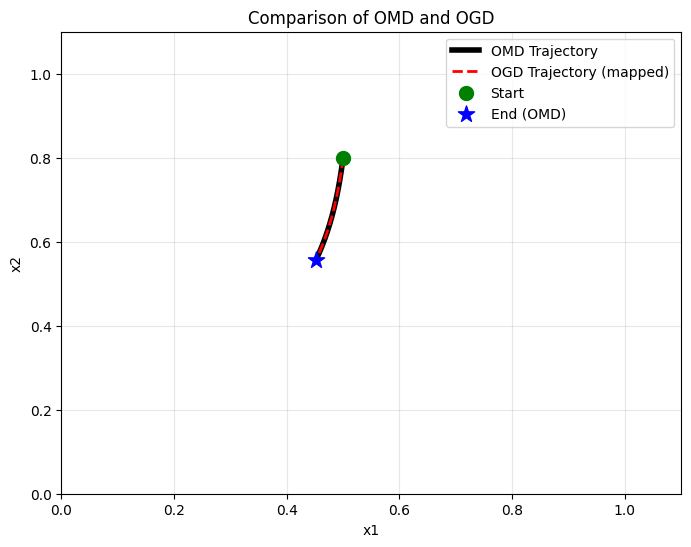

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable

@dataclass
class ProblemConfig:
    f: Callable[[np.ndarray], float]
    grad_f: Callable[[np.ndarray], np.ndarray]
    q: Callable[[np.ndarray], np.ndarray]
    inverse_q: Callable[[np.ndarray], np.ndarray]
    grad_q: Callable[[np.ndarray], np.ndarray]
    grad_R: Callable[[np.ndarray], np.ndarray]
    inverse_grad_R: Callable[[np.ndarray], np.ndarray]
    project_u: Callable[[np.ndarray], np.ndarray]
    project_x: Callable[[np.ndarray], np.ndarray]

def ogd_run(x_start, iterations, eta, p: ProblemConfig):
    u = p.inverse_q(x_start)
    trajectory_u = [u.copy()]

    for _ in range(iterations):
        x_curr = p.q(u)
        grad_ftilde = p.grad_f(x_curr) * p.grad_q(u)
        v = u - eta * grad_ftilde
        u = p.project_u(v)
        trajectory_u.append(u.copy())

    return np.array(trajectory_u)

def omd_run(x_start, iterations, eta, p: ProblemConfig):
    x = x_start.copy()
    trajectory_x = [x.copy()]

    for _ in range(iterations):
        dual_vector = p.grad_R(x) - eta * p.grad_f(x)
        y_next = p.inverse_grad_R(dual_vector)
        x = p.project_x(y_next)
        trajectory_x.append(x.copy())

    return np.array(trajectory_x)

def get_x4_exp_problem(lower_bound, upper_bound):
    u_min, u_max = np.log(lower_bound), np.log(upper_bound)

    return ProblemConfig(
        f=lambda x: np.sum(x**4),
        grad_f=lambda x: 4 * x**3,
        q=lambda u: np.exp(u),
        inverse_q=lambda x: np.log(x),
        grad_q=lambda u: np.exp(u),
        grad_R=lambda x: -1.0 / x,
        inverse_grad_R=lambda z: -1.0 / z,
        project_u=lambda u: np.clip(u, u_min, u_max),
        project_x=lambda x: np.clip(x, lower_bound, upper_bound)
    )

ETA = 0.001
T = 500
LB, UB = 0.001, 1.0
X0 = np.array([0.5, 0.8])

problem = get_x4_exp_problem(LB, UB)

traj_u_ogd = ogd_run(X0, T, ETA, problem)
traj_x_omd = omd_run(X0, T, ETA, problem)

traj_x_mapped_from_ogd = problem.q(traj_u_ogd)

plt.figure(figsize=(8, 6))
plt.plot(traj_x_omd[:, 0], traj_x_omd[:, 1], 'k-', linewidth=4, label='OMD Trajectory')
plt.plot(traj_x_mapped_from_ogd[:, 0], traj_x_mapped_from_ogd[:, 1], 'r--', linewidth=2, label='OGD Trajectory (mapped)')
plt.scatter(X0[0], X0[1], c='green', s=100, label='Start', zorder=5)
plt.scatter(traj_x_omd[-1, 0], traj_x_omd[-1, 1], c='blue', marker='*', s=150, label='End (OMD)', zorder=5)
plt.title("Comparison of OMD and OGD")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-4274131407.py:48: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f"B={b}, $\eta$={lr}\nRatio={lr/b:.4f}", fontsize=9)


Config       | Ratio    | Status
-----------------------------------


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


B32_LR0.075  | 0.0023   | Computed
B64_LR0.075  | 0.0012   | Computed
B128_LR0.075 | 0.0006   | Computed
B32_LR0.15   | 0.0047   | Computed
B64_LR0.15   | 0.0023   | Computed
B128_LR0.15  | 0.0012   | Computed
B32_LR0.3    | 0.0094   | Computed
B64_LR0.3    | 0.0047   | Computed
B128_LR0.3   | 0.0023   | Computed


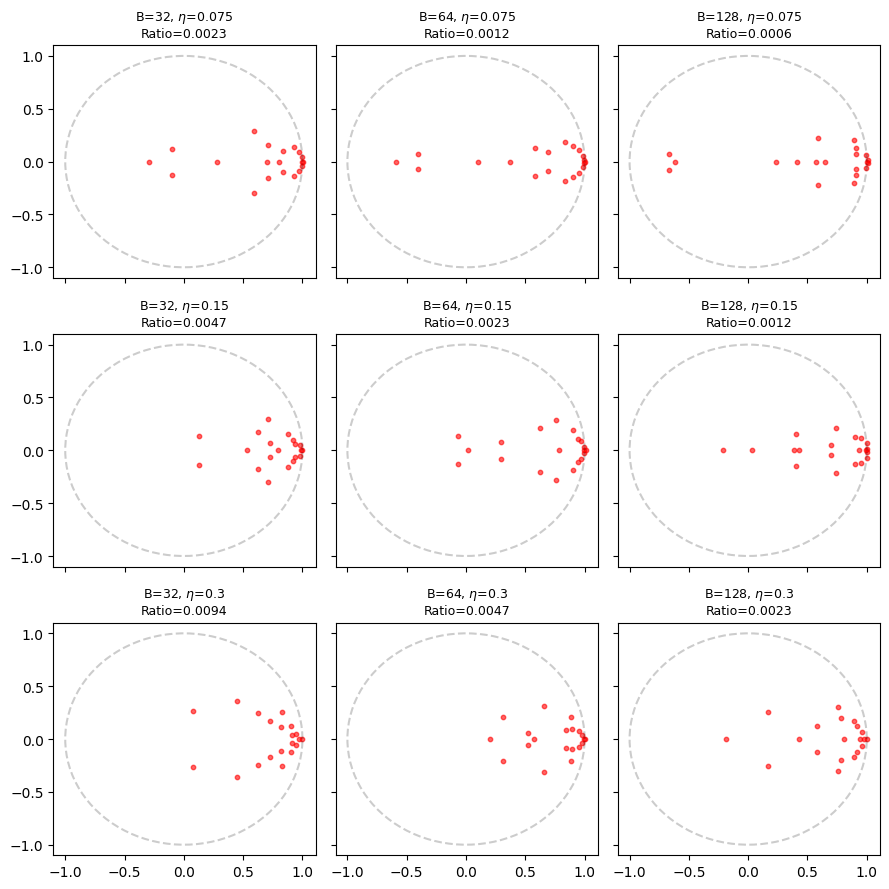


Spectral Distance Matrix (Wasserstein):
             B32_LR0.075  B64_LR0.075 B128_LR0.075   B32_LR0.15   B64_LR0.15  B128_LR0.15    B32_LR0.3    B64_LR0.3   B128_LR0.3
--------------------------------------------------------------------------------------------------------------------------------
B32_LR0.075       0.0000       0.1208       0.1416       0.1264       0.0854       0.1032       0.1372       0.1329       0.1049
B64_LR0.075       0.1208       0.0000       0.0744       0.1981       0.1279       0.1429       0.2027       0.1985       0.1568
B128_LR0.075      0.1416       0.0744       0.0000       0.2206       0.1569       0.1684       0.2248       0.2001       0.1872
B32_LR0.15        0.1264       0.1981       0.2206       0.0000       0.1124       0.1052       0.0936       0.0815       0.0950
B64_LR0.15        0.0854       0.1279       0.1569       0.1124       0.0000       0.0966       0.1342       0.1214       0.0984
B128_LR0.15       0.1032       0.1429       0.1684      

In [2]:
import torch, torch.nn as nn, torch.optim as optim, torchvision, numpy as np, matplotlib.pyplot as plt
import scipy.spatial.distance, warnings
from torchvision import transforms
from scipy.optimize import linear_sum_assignment
warnings.filterwarnings("ignore")

def get_loader(b):
    t = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    return torch.utils.data.DataLoader(torchvision.datasets.MNIST('./data', train=True, download=True, transform=t), batch_size=b, shuffle=True)

def train_dmd(b, lr, steps=150, rank=20):
    m = nn.Sequential(nn.Flatten(), nn.Linear(784, 10), nn.ReLU(), nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 10))
    opt, loss, snaps, l = optim.SGD(m.parameters(), lr=lr), nn.CrossEntropyLoss(), [], iter(get_loader(b))
    for _ in range(steps):
        try: x, y = next(l)
        except: l = iter(get_loader(b)); x, y = next(l)
        opt.zero_grad(); loss(m(x), y).backward(); opt.step()
        snaps.append(m[-1].weight.detach().cpu().numpy().flatten())

    d = np.array(snaps).T
    u, s, vh = np.linalg.svd(d[:, :-1], full_matrices=False)
    r = min(rank, len(s))
    return np.linalg.eigvals(u[:, :r].conj().T @ d[:, 1:] @ vh[:r, :].conj().T @ np.diag(1/s[:r]))

def wasserstein(e1, e2):
    d = scipy.spatial.distance.cdist(np.column_stack((e1.real, e1.imag)), np.column_stack((e2.real, e2.imag)))
    return d[linear_sum_assignment(d)].mean()

batches, lrs = [32, 64, 128], [0.075, 0.15, 0.3]
res, keys = {}, []
fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

print(f"{'Config':<12} | {'Ratio':<8} | Status")
print("-" * 35)

for i, lr in enumerate(lrs):
    for j, b in enumerate(batches):
        torch.manual_seed(42)
        k = f"B{b}_LR{lr}"
        keys.append(k)

        evals = train_dmd(b, lr)
        res[k] = evals

        ax = axs[i, j]
        ax.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--', alpha=0.2)
        ax.scatter(evals.real, evals.imag, c='r', s=10, alpha=0.6)
        ax.set_title(f"B={b}, $\eta$={lr}\nRatio={lr/b:.4f}", fontsize=9)
        print(f"{k:<12} | {lr/b:.4f}   | Computed")

plt.tight_layout(); plt.show()

print("\nSpectral Distance Matrix (Wasserstein):")
header = " " * 12 + " ".join([f"{k:>12}" for k in keys])
print(header + "\n" + "-" * len(header))
for k1 in keys:
    row = [f"{wasserstein(res[k1], res[k2]):.4f}" for k2 in keys]
    print(f"{k1:<12}" + " ".join([f"{r:>12}" for r in row]))